https://github.com/rolling-scopes-school/ml-intro/tree/2021/3_overfitting_regularization  
https://github.com/palinkapro/RS_check/blob/master/overfitting_regularization-final.ipynb  

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [6]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

In [7]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

def make_model(degree, alpha=0, penalty=None):
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

In [8]:
X, y = generate_samples()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [9]:
def get_coef(penalty, alpha):
    return make_model(degree=15, penalty=penalty, alpha=alpha).fit(X_train, y_train)['reg'].coef_

def get_avg_coef(penalty, alpha):
    results = cross_validate(make_model(degree=15, penalty=penalty, alpha=alpha), X, y, cv=5, return_estimator=True)
    return np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']])

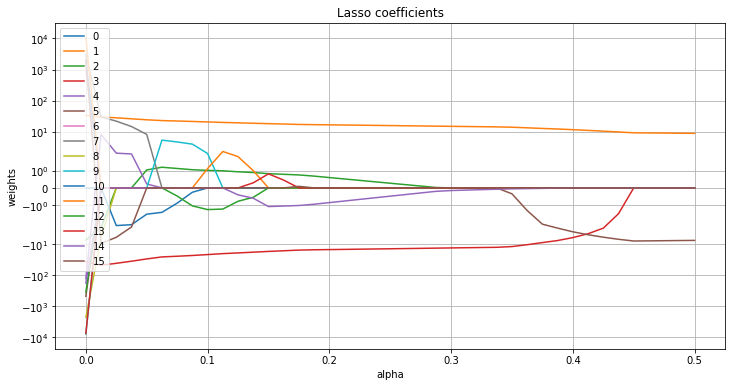

In [10]:
l1 = pd.DataFrame([get_coef('L1', alpha) for alpha in ALPHAS], index=ALPHAS)
ax = l1.plot(figsize=(12,6), logy='sym', use_index=True, grid=True)
ax.set(xlabel='alpha', ylabel='weights', title='Lasso coefficients');

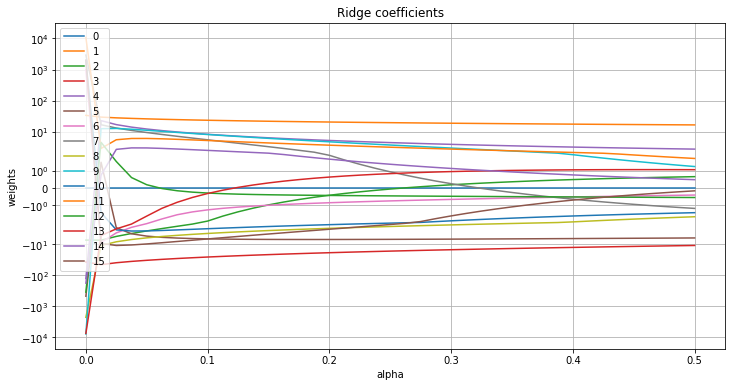

In [11]:
l2 = pd.DataFrame([get_coef('L2', alpha) for alpha in ALPHAS], index=ALPHAS)
ax = l2.plot(figsize=(12,6), logy='sym', use_index=True, grid=True);
ax.set(xlabel='alpha', ylabel='weights', title='Ridge coefficients');

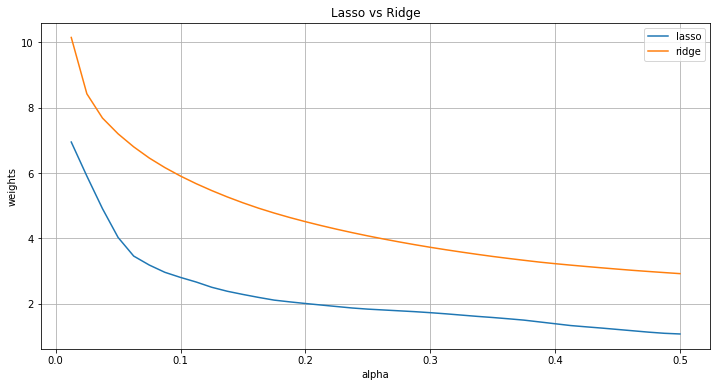

In [12]:
w1 = [get_avg_coef('L1', alpha) for alpha in ALPHAS]
w2 = [get_avg_coef('L2', alpha) for alpha in ALPHAS]
df = pd.DataFrame({'lasso':w1,'ridge':w2}, index=ALPHAS).iloc[1:,:]
ax = df.plot(figsize=(12,6), use_index=True, grid=True)
ax.set(xlabel='alpha', ylabel='weights', title='Lasso vs Ridge');

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [13]:
l1['zeros'] = l1.apply(lambda x: np.sum(x == 0), axis=1)
l1.round(2).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,zeros
0.0000,0.0,33.54,-7.40,-37.43,-127.81,-473.62,994.29,2910.25,-2261.14,-7770.36,1930.66,10759.22,-350.34,-7447.97,-179.92,2028.80,1
0.0125,0.0,29.88,-2.92,-47.58,8.18,0.00,-0.00,29.59,-5.98,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-9.51,9
0.0250,0.0,27.92,-0.00,-41.34,2.03,0.00,-0.00,21.83,-0.00,0.00,-2.52,0.00,-0.00,-0.00,-0.00,-6.00,10
0.0375,0.0,25.92,0.00,-35.35,1.97,0.00,-0.00,14.62,-0.00,0.00,-2.36,0.00,-0.00,-0.00,-0.00,-2.80,10
0.0500,0.0,24.11,1.04,-29.88,0.23,0.00,-0.00,8.16,-0.00,0.00,-1.52,0.00,-0.00,-0.00,-0.00,-0.00,10


In [14]:
l2['zeros'] = l2.apply(lambda x: np.sum(x == 0), axis=1)
l2.round(2).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,zeros
0.0000,0.0,33.54,-7.40,-37.43,-127.81,-473.62,994.29,2910.25,-2261.14,-7770.36,1930.66,10759.22,-350.34,-7447.97,-179.92,2028.80,1
0.0125,0.0,29.42,-7.45,-45.75,22.65,1.49,-8.82,16.70,-11.06,12.46,-1.43,2.90,4.54,-5.27,0.74,-9.52,1
0.0250,0.0,27.85,-5.63,-39.60,16.86,-2.95,-4.34,13.10,-8.39,12.71,-3.47,5.50,1.53,-3.22,2.69,-11.02,1
0.0375,0.0,26.74,-4.54,-35.87,14.02,-4.63,-2.87,10.96,-7.09,11.98,-3.78,6.04,0.60,-2.25,3.01,-10.62,1
0.0500,0.0,25.84,-3.76,-33.09,12.17,-5.50,-2.18,9.39,-6.27,11.10,-3.75,6.05,0.18,-1.63,3.00,-9.83,1


### Excercise 3 - Scaling (2 points)  

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?